## LMX Sentiment Demo

Implements simple quality diversity evolutionary algorithm (MAP-Elites) that searches the trade-off between similarity (as measured by an embedding model) and changed sentiment of an input sentence (e.g. it searches for how to maximally change sentiment while minimally modifying the sentence). Variation is generated by language model crossover (https://arxiv.org/abs/2302.12170). 

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

!pip install transformers
from transformers import pipeline

#can sub in whatever language model you want here...
#model_name = "EleutherAI/pythia-350m"
model_name = "EleutherAI/pythia-1.4b-deduped"

#device=0 = GPU; device=-1 = CPU
generator = pipeline('text-generation', model=model_name,device=0)  # for generating text
embed = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2',device=0) # for measuring diversity
sentiment_analysis = pipeline("sentiment-analysis",model="cardiffnlp/twitter-roberta-base-sentiment-latest",device=0) # for measuring quality

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=eb7ba957784d31904bf6e67a46d2c056818953e96e7c0d52255ceeef6a0d8074
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Evolution code




In [ ]:
import random 
from torch.cuda import seed_all
import numpy as np
from tensorflow.python.ops import gen_batch_ops

generator.tokenizer.pad_token_id = generator.model.config.eos_token_id

# euclidean distance
def dist(x,y):
  return np.sqrt( ((x-y)**2).sum() )

#make simple "crossover" prompt composed of random genomes from pop
def create_crossover_prompt(examples):
  prompt = ""
  for candidate in examples:
    prompt+=candidate+"\n"
  return prompt

#extract candidate offspring from response from LM
def sentiment_process_output(output,take_offspring=3,verbose=False):
  candidates = []
  genomes = output.split("\n")[:-1]
  genomes = [x.strip() for x in genomes]
  for genome in genomes[:take_offspring]:
      if len(genome)<10:
        if verbose: print(genome,'wrong length')
        continue
      if verbose: print(genome)
      candidates.append(genome)
  return list(set(candidates))

# bootstrap an initial population from using LMX on a few seed sentences
def sentiment_bootstrap_population_lmx(size=196,seed_sentences=[],batch_size=64,**kwargs):
  pop=seed_sentences[:]
  idx = 0
  num_examples = len(seed_sentences)

  while len(pop)<size:
    last_example = seed_sentences[idx%len(seed_sentences)]
    all_other_examples = set(seed_sentences)-set([last_example])
    #print(last_example,all_other_examples)
    examples = list(all_other_examples)
    random.shuffle(examples)
    examples = examples + [last_example]
    
    #print(examples)
    #print("doing crossover...")
    raw_crossovers = do_crossover_fast(None,chosen_examples=examples,examples=num_examples,batch_size=batch_size)
    for raw_crossover in raw_crossovers:
      pop+= process_output(raw_crossover,take_offspring=1)

    idx+=1
  return pop[:size]

# slight variant (always place target sentence at the end of few-shot prompt)
def sentiment_bootstrap_population_lmx_2(size=196,seed_sentences=[],target_sentence=None,batch_size=64,**kwargs):
  pop=seed_sentences[:]
  num_examples = len(seed_sentences)

  while len(pop)<size:
    last_example = target_sentence
    all_other_examples = set(seed_sentences)-set([last_example])
    #print(last_example,all_other_examples)
    examples = list(all_other_examples)
    random.shuffle(examples)
    examples = examples + [last_example]
    
    #print(examples)
    #print("doing crossover...")
    raw_crossovers = do_crossover_fast(None,chosen_examples=examples,examples=num_examples,batch_size=batch_size)
    for raw_crossover in raw_crossovers:
      pop+= process_output(raw_crossover,take_offspring=1)

  return pop[:size]


# batched LMX crossover
def do_crossover_fast(pop,examples=5,temp=1.0,batch_size=2,max_tokens=128,chosen_examples=None,prompt_generator=create_crossover_prompt):
  if chosen_examples==None:
    chosen_examples = np.random.choice(pop,examples,replace=False)

  prompt = prompt_generator(chosen_examples)

  model_output = generator([prompt]*batch_size,
                         batch_size=batch_size,
                         do_sample=True,
                         max_length=max_tokens,
                         temperature=temp,
                         #top_p=0.8,
                         #top_k=30,
                         #penalty_alpha=0.4, top_k=10,
                         return_full_text=False)
  output = [x[0]['generated_text'] for x in model_output]
  return output

# simple 1D map-elites implementation
class map_elites1d:
  def __init__(self,fitness_func,initial_pop,grid_sz=40,method="crossover",batch_size=8,temperature=1.0):
    self.temperature=temperature
    self.grid={}
    self.fitness_func = fitness_func
    self.grid_sz = grid_sz
    self.log = []
    self.evals = 0
    self.initial_pop = initial_pop
    self.method = method
    self.batch_size = batch_size

    for indiv in initial_pop:
      indiv = indiv.strip()
      fit,bc = self.fitness_func(indiv)
      self.evals+=1
      #print(fit,bc)
      self.insert(indiv,fit,bc)

  def eval_insert(self,indivs):
    for indiv in indivs:
      indiv = indiv.strip()
      fit,bc = self.fitness_func(indiv)
      self.evals+=1
      #print(fit,bc)
      self.insert(indiv,fit,bc)
    self.print_stats()

  def export(self):
    data = {}
    data['grid'] = self.grid
    data['log'] = self.log
    data['evals'] = self.evals
    data['method'] = self.method
    return data

  def to_bin(self,bc):
    bin = int(bc*(self.grid_sz))
    bin = min(self.grid_sz-1,bin)
    return bin
  
  def insert(self,indiv,fit,bc):
    bin = self.to_bin(bc)
    if bin not in self.grid or self.grid[bin]['fitness']<fit:
      self.grid[bin]={'fitness':fit,'bc':bc,'genome':indiv}

  def do_mutation(self):
    full_pop = self.gather_pop()
    parent = random.choice(full_pop)
    raw_mutations = do_mutation([parent],batch_size=self.batch_size)
    candidates = []
    for raw_mutation in raw_mutations:
      candidates += process_output(raw_mutation,take_offspring=1)
    for candidate in candidates:
      fit,bc = self.fitness_func(candidate)
      self.evals+=1
      self.insert(candidate,fit,bc)

  # LMX biased to use individuals nearby in map (sometimes increases performance)
  def do_crossover_near(self):
    full_pop = self.gather_pop()

    num_examples = 3

    if len(full_pop)<num_examples:
      print("...adding examples from initial pop...")
    while len(full_pop)<num_examples:
      full_pop.append(random.choice(self.initial_pop))

    idx = random.randint(0,len(full_pop)-1)
    dists = np.array([1.0 / (1+abs(idx-x)**3) for x in range(len(full_pop))])
    dists /= np.sum(dists)
    examples = np.random.choice(full_pop,p=dists,replace=False,size=num_examples)
    examples = list(examples)

    raw_crossovers = do_crossover(None,chosen_examples=examples,examples=num_examples,batch_size=self.batch_size,temp=self.temperature)

    candidates = []
    for raw_crossover in raw_crossovers:
      candidates += process_output(raw_crossover,take_offspring=1)

    candidates = [candidate.strip() for candidate in candidates]

    for candidate in candidates:
      fit,bc = self.fitness_func(candidate)
      self.evals+=1
      self.insert(candidate,fit,bc)
  
  
  # LMX with random parents from map
  def do_crossover(self):
    full_pop = self.gather_pop()

    num_examples = 3

    if len(full_pop)<num_examples:
      print("...adding examples from initial pop...")
    while len(full_pop)<num_examples:
      full_pop.append(random.choice(self.initial_pop))

    raw_crossovers = do_crossover(full_pop,examples=num_examples,batch_size=self.batch_size,temp=self.temperature)

    candidates = []
    for raw_crossover in raw_crossovers:
      candidates += process_output(raw_crossover,take_offspring=1)

    candidates = [candidate.strip() for candidate in candidates]
    for candidate in candidates:
      fit,bc = self.fitness_func(candidate)
      self.evals+=1
      self.insert(candidate,fit,bc)
      
  # main evolution loop
  def do_evals(self,num_evals=300):
    idx=0
    while self.evals < num_evals:
      if self.method=='crossover':
        self.do_crossover()
      elif self.method=='crossover-near':
        self.do_crossover_near()
      elif self.method=='crossover-mixed':
        if random.random() < 0.5:
          self.do_crossover()
        else:
          self.do_crossover_near()
      else:
        raise "no variation operator by name {name}".format(name=self.method)
      if idx%1==0:
        print(idx,self.evals)
        self.print_stats()
      idx+=1

  def gather_pop(self):
    keys = list(self.grid.keys())
    keys.sort()
    pop = [self.grid[key]['genome'] for key in keys]
    return pop

  def print_stats(self):
    niches = len(list(self.grid.keys()))
    qd_score = sum([self.grid[key]['fitness'] for key in self.grid.keys()])
    pop = self.gather_pop()
    pts = [(self.grid[key]['fitness'],self.grid[key]['bc']) for key in self.grid.keys()]
    self.log.append({'qd_score':qd_score,'niches':niches,'pts':pts,'evals':self.evals})
    print('# niches: {niches}, qd score: {qd_score}'.format(niches=niches,qd_score=qd_score))

def mapelites_sentiment_fitness(x):
  global root_embedding
  global sentiment_class
  res = sentiment_analysis(x,top_k=3)
  emb = embed.encode([x])[0]
  d = dist(emb,root_embedding)
  bc = d
  for k in res:
    if k['label']==sentiment_class:
      #print(x,k['score'])
      fit = k['score']
      break
  #normalize bc between 0 and 1.25
  bc = max(0,bc)
  bc = min(1.25,bc)
  bc = bc/1.25
  return fit,bc


In [ ]:
# some default sentence collections 
negative_sentences = ["The moon is a boring sky rock.","Puppies are smelly, ill-behaved animals that make everything worse.","I really really hated my trip to the amusement park, I threw up on a roller coaster and was robbed by a Elvis impersonator."]
negative_quotes = ["Whenever a friend succeeds, a little something in me dies.","Kids, you tried your best and you failed miserably. The lesson is, never try.","Life is divided into the horrible and the miserable."]
#positive_sentences = ["Chocolate is such a very, very amazing dessert.","I really love my pet iguana, Iggy.","Rainbows and waterfalls are so beautiful -- they make me so very happy."]
#positive_quotes = ['Few things can help an individual more than to place responsibility on him, and to let him know that you trust him.','Be the change that you wish to see in the world.','When the sun is shining I can do anything; no mountain is too high, no trouble too difficult to overcome.']

create_population = sentiment_bootstrap_population_lmx
do_crossover = do_crossover_fast
process_output = sentiment_process_output

root_sentence = negative_sentences[0]
root_embedding = None

# sentiment class to target -- recommend "positive" or "neutral"; "negative" often generates toxic output
sentiment_class = "positive"
seed_sentences = negative_sentences

def do_run(_root_sentence,_sentiment_class,total_evals=1200,method="crossover",initial_pop=None,batch_size=64):
  global sentiment_class,root_sentence,root_embedding
  root_sentence = _root_sentence
  sentiment_class = _sentiment_class
  root_embedding = embed.encode([root_sentence])[0]

  pop=initial_pop

  me = map_elites1d(mapelites_sentiment_fitness,pop,grid_sz=30,method=method,batch_size=batch_size,temperature=0.8)
  me.do_evals(total_evals)
  return me

# Run evolution

In [ ]:
#decrease batch size if you run into memory issues
batch_size = 64

# one of the examples from the paper; note that "seeds" should be of length ~3 and contain one copy of the target sentence
target_sentence = negative_quotes[1]
sentiment = "positive"
seeds = negative_quotes

# simple custom example
#target_sentence = "The terrible day would never end."
#sentiment = "positive"
#seeds = [target_sentence, "The awful day would never end.","The bad day seemed like it would never end."]

print("Target sentence:", target_sentence)
print("Seeds:",seeds)

initial_pop = create_population(size=batch_size * 5,seed_sentences=seeds,target_sentence=target_sentence,batch_size=batch_size)
evals = 2500
results = do_run(target_sentence,sentiment,evals,"crossover-near",initial_pop=initial_pop,batch_size=batch_size)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Target sentence: Kids, you tried your best and you failed miserably. The lesson is, never try.
Seeds: ['Whenever a friend succeeds, a little something in me dies.', 'Kids, you tried your best and you failed miserably. The lesson is, never try.', 'Life is divided into the horrible and the miserable.']


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0 345
# niches: 12, qd score: 8.166953891515732


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


1 367
# niches: 12, qd score: 9.317493513226509


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


2 415
# niches: 12, qd score: 9.43119366466999


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


3 461
# niches: 12, qd score: 9.456150129437447


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


4 503
# niches: 12, qd score: 9.486695244908333


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


5 557
# niches: 12, qd score: 9.487474873661995


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


6 615
# niches: 12, qd score: 9.544002905488014


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


7 650
# niches: 13, qd score: 10.421326532959938


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


8 680
# niches: 13, qd score: 10.421614363789558


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


9 738
# niches: 22, qd score: 11.029029443860054


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


10 793
# niches: 24, qd score: 11.205020390450954


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


11 838
# niches: 24, qd score: 11.753654636442661


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


12 900
# niches: 24, qd score: 12.849533211439848


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


13 942
# niches: 26, qd score: 13.109544795006514


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


14 990
# niches: 26, qd score: 13.265495952218771


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


15 1039
# niches: 26, qd score: 14.629033785313368


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


16 1095
# niches: 26, qd score: 14.634389501065016


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


17 1153
# niches: 26, qd score: 16.654514607042074


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


18 1211
# niches: 26, qd score: 16.654731269925833


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


19 1265
# niches: 27, qd score: 18.87494282796979


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


20 1306
# niches: 27, qd score: 18.87494282796979


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


21 1339
# niches: 27, qd score: 18.87494282796979


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


22 1402
# niches: 27, qd score: 18.87494282796979


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


23 1452
# niches: 27, qd score: 18.87902051396668


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


24 1480
# niches: 27, qd score: 18.881355108693242


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


25 1532
# niches: 27, qd score: 19.05023062415421


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


26 1595
# niches: 27, qd score: 19.05023062415421


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


27 1648
# niches: 27, qd score: 19.063386606052518


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


28 1703
# niches: 27, qd score: 19.121430860832334


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


29 1755
# niches: 27, qd score: 19.121430860832334


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


30 1801
# niches: 27, qd score: 19.538338981568813


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


31 1824
# niches: 27, qd score: 19.5547581538558


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


32 1884
# niches: 27, qd score: 19.5547581538558


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


33 1939
# niches: 29, qd score: 19.60045788064599


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


34 2000
# niches: 29, qd score: 19.60045788064599


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


35 2048
# niches: 29, qd score: 19.613602254539728


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


36 2101
# niches: 29, qd score: 19.643831703811884


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


37 2143
# niches: 29, qd score: 19.72398767247796


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


38 2186
# niches: 29, qd score: 19.724418554455042


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


39 2233
# niches: 29, qd score: 19.77298418059945


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


40 2282
# niches: 29, qd score: 20.722136203199625


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


41 2331
# niches: 29, qd score: 20.838030638173223


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


42 2389
# niches: 29, qd score: 20.887244464829564


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


43 2438
# niches: 29, qd score: 20.973177494481206


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


44 2493
# niches: 29, qd score: 20.973406119272113
45 2549
# niches: 29, qd score: 20.98335717432201


# Display results

20.98335717432201


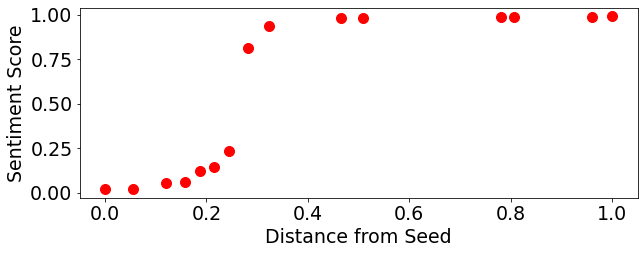

Distance | Sentiment | Genome
0.00 & 0.02 & Kids, you tried your best and you failed miserably. The lesson is, never try. 
0.05 & 0.02 & Kids, you tried your best, and you failed miserably. The lesson is, never try. 
0.12 & 0.05 & Kids, you tried your best and you failed miserably. The lesson is, never stop trying. 
0.16 & 0.06 & Kids, you tried your best, and failed miserably. The lesson is, never stop trying. 
0.19 & 0.12 & Kids, you tried your best, and you failed. The lesson is, never stop trying. 
0.21 & 0.14 & Kids, you tried your best, and failed. The lesson is, never stop trying. 
0.24 & 0.24 & Kids, you tried your best, and you failed. The lesson is, always succeed. 
0.28 & 0.81 & Kids, you tried your best. The lesson is, never fail. 
0.32 & 0.94 & Kids, you tried your best, and you won. The lesson is, always succeed. 
0.47 & 0.98 & Kids, you are the best. The lesson is, never fail. 
0.51 & 0.98 & Kids, you’re the best thing that’s ever happened to me. And the lesson is, never

In [ ]:
import pylab
me = results

print(me.log[-1]['qd_score'])
keys = list(me.grid.keys())
fit = [me.grid[key]['fitness'] for key in keys]
bc = [me.grid[key]['bc'] for key in keys]
genome = [me.grid[key]['genome'] for key in keys]

def dominated(b,a):
  return a[0]<b[0] and a[1]>b[1]

is_dominated = [False]*len(bc)
for i in range(len(bc)):
    for j in range(len(bc)):
        if dominated((bc[i],fit[i]),(bc[j],fit[j])):
            is_dominated[i] = True
            break

# remove dominated points
bc = [bc[i] for i in range(len(bc)) if not is_dominated[i]]
fit = [fit[i] for i in range(len(fit)) if not is_dominated[i]]
genome = [genome[i] for i in range(len(genome)) if not is_dominated[i]]

#plot pareto front
pylab.figure(figsize=(10,3.5))
# make font bigger
pylab.rcParams.update({'font.size': 19})
# make points bigger
pylab.rcParams['lines.markersize'] = 10

pylab.plot(bc,fit,"ro")
pylab.ylabel("Sentiment Score")
pylab.xlabel("Distance from Seed")

pylab.show()
res = list(zip(bc,fit,genome))
res.sort(key=lambda x: x[0])

#print out full results
print("Distance | Sentiment | Genome")
for ind in res:
    _bc,_fit,_genome = ind
    # format bc and fit to be 2 decimal places
    _bc = "{:.2f}".format(_bc)
    _fit = "{:.2f}".format(_fit)
    # write to a latex table
    print(f"{_bc} & {_fit} & {_genome} ")